# ATP Tennis Data - Other Classifiers

In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/4-atp_logistic_regression.ipynb), we used logistic regression to see how accurately we can predict winners and losers of a tennis match. In this notebook, we will use a number of different classifiers to see how they perform.


Summary of findings from previous notebook:

* diffing player stats was a better way of engineering our features
* loading more data (older that 1998, didn't help with our prediction)

Results from logistic regression:
```
              precision    recall  f1-score   support

        Loss       0.69      0.66      0.67     12468
         Win       0.68      0.71      0.69     12521

    accuracy                           0.68     24989
   macro avg       0.68      0.68      0.68     24989
weighted avg       0.68      0.68      0.68     24989
```


Again, our null hypothesis is that we can predict purely based on the player ranking - so our baseline is ~65% accruracy if we use match data from 1998 to present.

We will use the following classifiers - all using default settings
* KNN
* Random Forest
* SVC


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# files
DATASET_DIR = '../datasets'

START_YEAR = 1998
END_YEAR = 2019

FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1998-2029_features-diff-ohe.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2029_features-diff-ohe.csv'

MODEL_DIR = '../models'
MODEL_FILE_KNN = f'{MODEL_DIR}/knn-{START_YEAR}-{END_YEAR}-diff.pkl'
MODEL_FILE_SVC = f'{MODEL_DIR}/svc-{START_YEAR}-{END_YEAR}-diff.pkl'
MODEL_FILE_RF = f'{MODEL_DIR}/rf-{START_YEAR}-{END_YEAR}-diff.pkl'

REPORT_DIR = '../reports'
REFPORT_FILE = f'{REPORT_DIR}/report.csv'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [3]:
def analyze_predictions(y_test, y_predict, y_predict_proba=None):
    if y_predict_proba:
        print(roc_auc_score(y_test, y_predict_proba))
    
    print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))
    cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
    print(cm)
    sns.heatmap(cm, annot=True)

In [4]:
from sklearn.preprocessing import MinMaxScaler


def plot_2d(X_test, y_predict):
    """
    Use PCA to dimensionality reduction then plot win vs loses
    :param: X_test - test features
    :param: y_predict - predictions from model
    """
    
    # normalize our data first before using PCA so weights are the same for all variables
    mms = MinMaxScaler()
    normalized_df = X_test.copy()
    for col in normalized_df.columns:
        normalized_col = mms.fit_transform([normalized_df[col].values])
        normalized_df[col] = normalized_col[-1]
    

    # reduce X to 2D
    X_test_2d = pd.DataFrame(PCA(n_components=2).fit_transform(X_test))

    # let's figure out which ones of these are predicted Wins
    wins = X_test_2d[y_predict == 1]

    # entries that are predicted losses
    losses = X_test_2d[y_predict == 0]

    f, a = plt.subplots(1, 1, figsize=(20,5))
    p = sns.scatterplot(x=0, y=1, data=losses, ax=a, color='r', alpha=0.5)
    p = sns.scatterplot(x=0, y=1, data=wins, ax=a, color='b', alpha=0.5)


# KNN

In [5]:
# extract features and labels
features = pd.read_csv(f'{FEATURE_FILE_DIFF}')
labels = features[LABEL_COL].copy()
features = features.drop([LABEL_COL], axis=1)

# train our model
X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, random_state=RSTATE)
knn = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)


In [6]:
knn.score(X_test, y_test)

0.6091795119928112

              precision    recall  f1-score   support

        Loss       0.60      0.62      0.61      7115
         Win       0.62      0.60      0.61      7352

    accuracy                           0.61     14467
   macro avg       0.61      0.61      0.61     14467
weighted avg       0.61      0.61      0.61     14467

      Loss   Win
Loss  4437  2678
Win   2976  4376


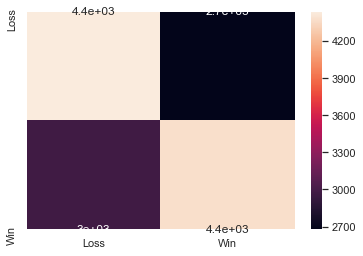

In [7]:
analyze_predictions(y_test, y_predict_knn)

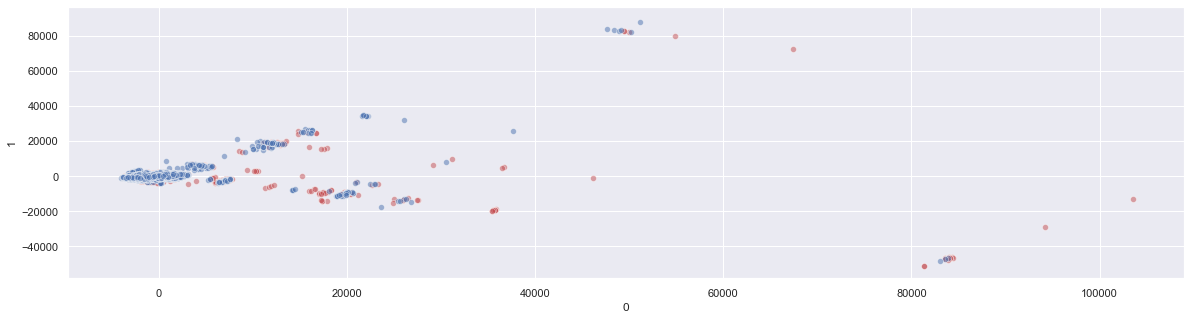

In [8]:
plot_2d(X_test, y_predict_knn)

In [9]:
pickle.dump(knn, open(MODEL_FILE_KNN, 'wb'))

# Let's try SVC

In [10]:
from sklearn.svm import SVC

svc = SVC().fit(X_train, y_train)
y_predict_svc = svc.predict(X_test)
svc.score(X_test, y_test)

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4968549111771618

              precision    recall  f1-score   support

        Loss       0.49      1.00      0.66      7115
         Win       0.92      0.01      0.02      7352

    accuracy                           0.50     14467
   macro avg       0.71      0.50      0.34     14467
weighted avg       0.71      0.50      0.34     14467

      Loss  Win
Loss  7108    7
Win   7272   80


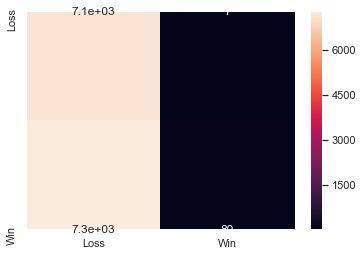

In [11]:
analyze_predictions(y_test, y_predict_svc)

Wow.. SVC is pretty much prediction all matches at a lost which would make sense that our precision is around 50% as our data is balanced, but you can see that recall is at 1% meaning it's only 1% effective at actually identifying wins

### Let's visualize our classification

We will use PCA to reduce the dimensions to 2D then graph our data

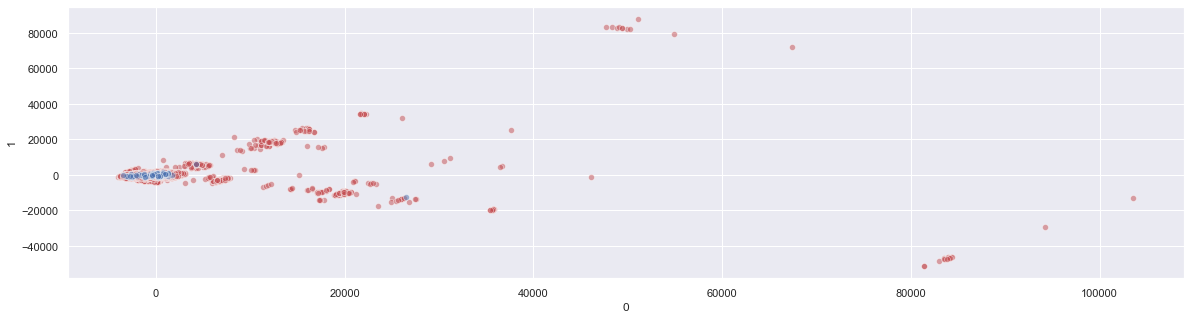

In [12]:
plot_2d(X_test, y_predict_svc)

In [13]:
pickle.dump(knn, open(MODEL_FILE_SVC, 'wb'))

# Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)
rf.score(X_test, y_test)

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8521462639109698

              precision    recall  f1-score   support

        Loss       0.82      0.90      0.86      7115
         Win       0.89      0.81      0.85      7352

    accuracy                           0.85     14467
   macro avg       0.85      0.85      0.85     14467
weighted avg       0.86      0.85      0.85     14467

      Loss   Win
Loss  6375   740
Win   1399  5953


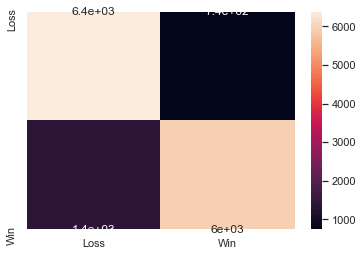

In [15]:
analyze_predictions(y_test, y_predict_rf)

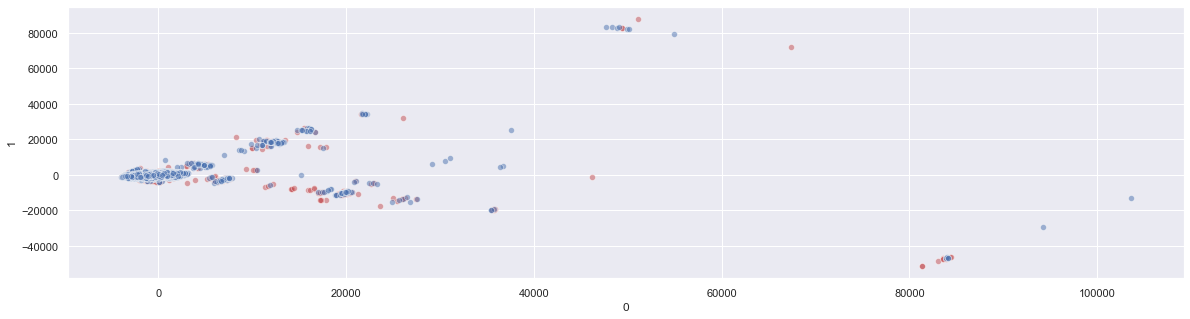

In [16]:
plot_2d(X_test, y_predict_rf)

In [17]:
pickle.dump(knn, open(MODEL_FILE_RF, 'wb'))

### Let's see if we can explain what Random Forest is Doing



In [35]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


In [39]:
X_test.shape

(14467, 17)

In [98]:
shap_df = pd.DataFrame(shap_values[-1], columns=X_test.columns)
print(shap_df.shape)
shap_df.head()


(14467, 17)


,age_diff,draw_size,ht_diff,p1,p1_hand,p1_ioc,p2,p2_hand,p2_ioc,rank_diff,round_label,seed_diff,surface_label,tourney_id_label,tourney_level_label,tourney_month,tourney_year
0,0.023133,0.075245,-0.006363,-0.013915,0.000208,-0.003718,0.001604,-0.000152,-0.008651,-0.113963,0.044178,-0.062673,-0.013282,0.010919,-0.016245,-0.001531,-0.011913
1,0.017630,-0.022473,0.056372,0.049405,0.004182,-0.007059,0.060784,0.003832,0.005900,0.098643,0.009675,0.151988,-0.016315,0.008372,-0.012259,0.000207,-0.006004
2,0.005639,-0.001878,0.007188,0.012332,0.000007,0.017911,0.003951,-0.000004,0.002336,0.093125,0.008804,0.347284,0.001699,-0.003343,0.002618,0.001047,0.004164
3,-0.019912,0.045113,0.003847,-0.013479,-0.005249,-0.049984,0.002207,0.002735,-0.003176,-0.093623,-0.001598,0.018357,-0.003777,-0.031611,-0.045959,-0.000556,-0.000453
4,0.041407,0.071761,0.042229,-0.013279,0.000359,0.015382,0.004825,-0.000497,0.000389,-0.053020,0.014118,-0.113952,-0.012067,0.002294,0.027764,0.001478,-0.026310


In [37]:
print('Expected Value:', explainer.expected_value)


Expected Value: [0.5028801187872887, 0.49711987376213074]


### Let's look at some predictions that were correct and which ones were not

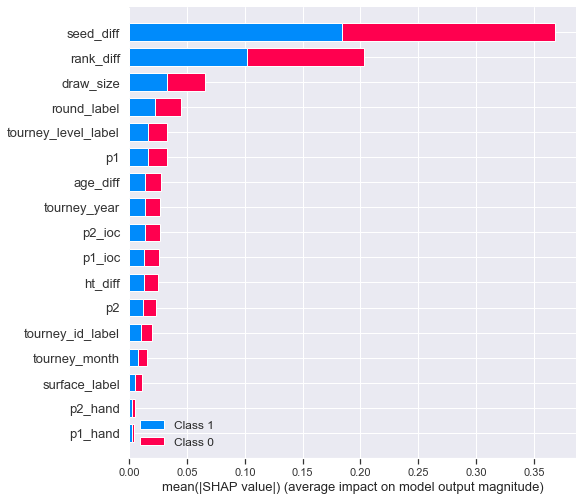

In [86]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [82]:
correct_indexes = (y_predict_rf == y_test.tolist())
correct_indexes

array([False,  True,  True, ...,  True,  True,  True])

### Correctly predicted entry

In [83]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1][:], X_test.iloc[1,:], feature_names=X_test.columns)

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][2][:], X_test.iloc[2,:], feature_names=X_test.columns)

### Incorrectly predicted entry

For this entry, model predicted that p1 will lose to 2. However, the correct result should have been p1 beats p2

* You see that draw size played a much bigger role in determine the outcome
* round lable in previous entry actually helped us predict p1 will be p2 but in this one, it played a big role in predicting the wrong result


In [101]:
y_predict_rf[0]

0.0

In [100]:
y_test.iloc[0]

1.0

In [103]:
X_test.iloc[0]

age_diff                   -4.62
draw_size                  64.00
ht_diff                    -2.00
p1                     103063.00
p1_hand                     1.00
p1_ioc                     29.00
p2                     102179.00
p2_hand                     1.00
p2_ioc                     29.00
rank_diff                  93.00
round_label                 6.00
seed_diff                  11.60
surface_label               3.00
tourney_id_label           83.00
tourney_level_label         4.00
tourney_month               7.00
tourney_year             2004.00
Name: 19830, dtype: float64

In [77]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0][:], X_test.iloc[0,:], feature_names=X_test.columns)

In [105]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:1000][:], X_test.iloc[:1000,:], feature_names=X_test.columns)


In [ ]:
shap.image_plot(shap_values[0], X_test, labels=y_predict_rf)

### Partical Dependence Plots

Background:
* If player 1 is ranked higher (ie, #1) than player 2 (ie, #5), seed_diff is negative -> player 1 is expected to beat player 2
* Conversely if player 1 has lower rank than player 2, seed_diff is positive -> player 2 is expected to beat player 1


The higher the absolute value here (ie, left and right edges of graph), this indications that more the difference in rank.

As expected, if number is negative, you would tend to predict p1 as winner. If number is postive, you would predict winner is p2.

Interestly, you see that if Player 1 is a higher rank than player 2, the more the difference, this information contributes more to predicting player 1 will win. However, if player 1 is ranked lower than player 2, as the difference is more, this does not contribute as much to model predicting losses.

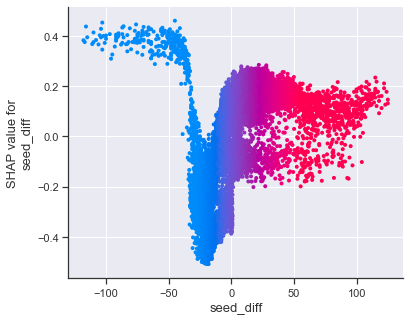

In [92]:
shap.dependence_plot(ind='seed_diff', interaction_index='seed_diff',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test)

In [ ]:
shap.dependence_plot(ind='age_diff', interaction_index='age_diff',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test)

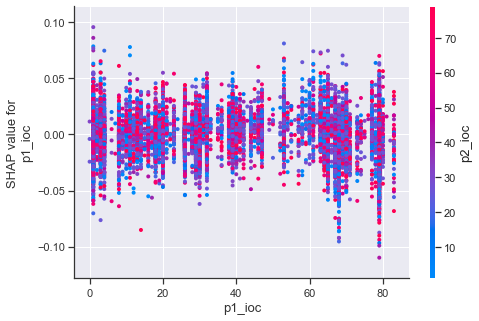

In [106]:
shap.dependence_plot(ind='p1_ioc', interaction_index='p2_ioc',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test)